### In this notebook:
XGBoost take as input:
- ERA5 values on the last 30 days
- Output of the encoder for MJO-ENSO variables
- Output of the encoder for the 10 days timeseries of ERA5 variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('./drive/My Drive/Tropical_Cyclones_Thesis/ERA5_Dataset')

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model


import pickle
import metrics
import datashift

In [ ]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

 # Loading Datasets

In [ ]:
X_test_xgb = []
y_test_xgb = []

X_test_lstm_mjo  = []
X_test_lstm_era5 = []
y_test_lstm = []

X_test_hybrid = []
y_test_hybrid = []


for i in range(10):
  X_test_xgb.append(np.load('./10_Black_Boxes/test_sets/X_test_xgb_t+{}.npy'.format(i+1)))
  y_test_xgb.append(np.load('./10_Black_Boxes/test_sets/y_test_xgb_t+{}.npy'.format(i+1)))

  X_test_lstm_mjo.append(np.load('./10_Black_Boxes/test_sets/X_test_lstm_mjo_t+{}.npy'.format(i+1)))
  X_test_lstm_era5.append(np.load('./10_Black_Boxes/test_sets/X_test_lstm_era5_t+{}.npy'.format(i+1)))
  y_test_lstm.append(np.load('./10_Black_Boxes/test_sets/y_test_lstm_t+{}.npy'.format(i+1)))

  X_test_hybrid.append(np.load('./10_Black_Boxes/test_sets/X_test_hybrid_t+{}.npy'.format(i+1)))
  y_test_hybrid.append(np.load('./10_Black_Boxes/test_sets/y_test_hybrid_t+{}.npy'.format(i+1)))

# Evalute models

In [ ]:
from keras.models import load_model

max_lead_time = 10
ensemble_models = []
xgb_models = []
lstm_models = []

for i in range(max_lead_time):
  ensemble_models.append(pickle.load(open('./10_Black_Boxes/models/Hybrid/XGBoost_ENS_t+{}.dat'.format(i+1), "rb")))

for i in range(max_lead_time):
  xgb_models.append(pickle.load(open('./10_Black_Boxes/models/XGBoost/XGBoost_t+{}.dat'.format(i+1), "rb")))

for i in range(max_lead_time):
  lstm_models.append(load_model('./10_Black_Boxes/models/LSTM_Networks/LSTM_MJO_ENSO_ERA5_t+{}.h5'.format(i)))

In [ ]:
import sklearn
predictions_xgb = []

for i in range(max_lead_time):
  prediction = xgb_models[i].predict(X_test_xgb[i]).transpose()
  predictions_xgb.append(prediction)
  accuracy = sklearn.metrics.accuracy_score(y_test_xgb[i], prediction)
  recall   = sklearn.metrics.recall_score(y_test_xgb[i], prediction)
  f1       = sklearn.metrics.f1_score(y_test_xgb[i], prediction)

  print('Evaluation at t+{}'.format(i+1))
  print('ACCURACY: ', accuracy, 'RECALL: ', recall, 'F1: ', f1)
  print('------------------------------------------------------')

Evaluation at t+1
ACCURACY:  0.8894059676977827 RECALL:  0.7519685039370079 F1:  0.654109589041096
------------------------------------------------------
Evaluation at t+2
ACCURACY:  0.8737677984665937 RECALL:  0.6968503937007874 F1:  0.6056458511548332
------------------------------------------------------
Evaluation at t+3
ACCURACY:  0.8652423993426458 RECALL:  0.6850393700787402 F1:  0.5858585858585857
------------------------------------------------------
Evaluation at t+4
ACCURACY:  0.8512328767123287 RECALL:  0.6633858267716536 F1:  0.5538208709942481
------------------------------------------------------
Evaluation at t+5
ACCURACY:  0.8289942449986297 RECALL:  0.6220472440944882 F1:  0.5031847133757962
------------------------------------------------------
Evaluation at t+6
ACCURACY:  0.8146929824561403 RECALL:  0.5846456692913385 F1:  0.46771653543307085
------------------------------------------------------
Evaluation at t+7
ACCURACY:  0.8034000548395942 RECALL:  0.48818897637

In [ ]:
def binarize_arr(arr):
  new_arr = []
  for elem in arr:
    if elem >= 0.5:
      new_arr.append(1)
    else:
      new_arr.append(0)
  return new_arr

In [ ]:
predictions_lstm = []

for i in range(max_lead_time):
  prediction = lstm_models[i].predict([X_test_lstm_mjo[i], X_test_lstm_era5[i]]).transpose()[0]
  prediction = binarize_arr(prediction)
  predictions_lstm.append(prediction)
  # print(prediction)
  # print(y_test_lstm[i])
  accuracy = sklearn.metrics.accuracy_score(y_test_lstm[i], prediction)
  recall   = sklearn.metrics.recall_score(y_test_lstm[i], prediction)
  f1       = sklearn.metrics.f1_score(y_test_lstm[i], prediction)

  print('Evaluation at t+{}'.format(i+1))
  print('ACCURACY: ', accuracy, 'RECALL: ', recall, 'F1: ', f1)
  print('------------------------------------------------------')

115/115 [==============================] - 1s 8ms/step
Evaluation at t+1
ACCURACY:  0.8792773063235697 RECALL:  0.8366141732283464 F1:  0.6584043377226956
------------------------------------------------------
115/115 [==============================] - 1s 8ms/step
Evaluation at t+2
ACCURACY:  0.8849945235487404 RECALL:  0.8165680473372781 F1:  0.6634615384615385
------------------------------------------------------
115/115 [==============================] - 1s 8ms/step
Evaluation at t+3
ACCURACY:  0.8247055601205149 RECALL:  0.8478260869565217 F1:  0.5727636849132176
------------------------------------------------------
115/115 [==============================] - 1s 8ms/step
Evaluation at t+4
ACCURACY:  0.8457534246575342 RECALL:  0.7841584158415842 F1:  0.5845018450184503
------------------------------------------------------
115/115 [==============================] - 1s 9ms/step
Evaluation at t+5
ACCURACY:  0.8141956700465881 RECALL:  0.7936507936507936 F1:  0.5412719891745602
-----

In [ ]:
import sklearn
predictions_hybrid = []

for i in range(max_lead_time):
  prediction = ensemble_models[i].predict(X_test_hybrid[i]).transpose()
  predictions_hybrid.append(prediction)
  accuracy = sklearn.metrics.accuracy_score(y_test_hybrid[i], prediction)
  recall   = sklearn.metrics.recall_score(y_test_hybrid[i], prediction)
  f1       = sklearn.metrics.f1_score(y_test_hybrid[i], prediction)

  print('Evaluation at t+{}'.format(i+1))
  print('ACCURACY: ', accuracy, 'RECALL: ', recall, 'F1: ', f1)
  print('------------------------------------------------------')

Evaluation at t+1
ACCURACY:  0.9208869422392554 RECALL:  0.7322834645669292 F1:  0.7202323330106485
------------------------------------------------------
Evaluation at t+2
ACCURACY:  0.9159364731653888 RECALL:  0.6988188976377953 F1:  0.6981317600786627
------------------------------------------------------
Evaluation at t+3
ACCURACY:  0.8915365653245686 RECALL:  0.5885826771653543 F1:  0.6016096579476861
------------------------------------------------------
Evaluation at t+4
ACCURACY:  0.8742465753424657 RECALL:  0.4881889763779528 F1:  0.5193717277486911
------------------------------------------------------
Evaluation at t+5
ACCURACY:  0.8646204439572486 RECALL:  0.4330708661417323 F1:  0.47109207708779444
------------------------------------------------------
Evaluation at t+6
ACCURACY:  0.8571820175438597 RECALL:  0.3661417322834646 F1:  0.4165733482642778
------------------------------------------------------
Evaluation at t+7
ACCURACY:  0.8511105017822869 RECALL:  0.2814960629

# Evaluate XGBoost model

In [128]:
from sklearn.metrics import confusion_matrix

tp_arr = []
tn_arr = []
fp_arr = []
fn_arr = []

for i in range(10):
  tn, fp, fn, tp = confusion_matrix(y_test_xgb[i], predictions_xgb[i]).ravel()
  tp_arr.append(tp)
  tn_arr.append(tn)
  fp_arr.append(fp)
  fn_arr.append(fn)

tp_xgb = tp_arr
tn_xgb = tn_arr
fp_xgb = fp_arr
fn_xgb = fn_arr

In [129]:
acc_xgb   = []
rec_xgb   = []
prec_xgb  = []
f1_xgb    = []
far_xgb   = []

for i in range(10):
  acc_xgb.append(sklearn.metrics.accuracy_score(y_test_xgb[i], predictions_xgb[i]))
  rec_xgb.append(sklearn.metrics.recall_score(y_test_xgb[i], predictions_xgb[i]))
  prec_xgb.append(sklearn.metrics.precision_score(y_test_xgb[i], predictions_xgb[i]))
  f1_xgb.append(sklearn.metrics.f1_score(y_test_xgb[i], predictions_xgb[i]))
  far_xgb.append(fp_arr[i]/(fp_arr[i]+tp_arr[i]))

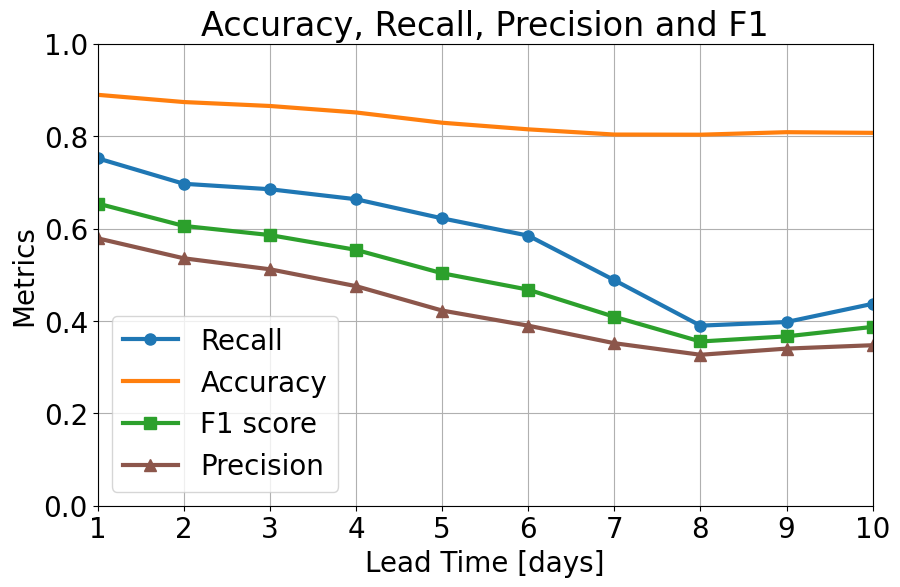

In [130]:
import matplotlib

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined
# Plotting POD
plt.plot(x, rec_xgb, label='Recall', marker='o', color='C0', linewidth=3, markersize=8)
# Plotting Accuracy
plt.plot(x, acc_xgb, label='Accuracy', color='C1', linewidth=3, markersize=8)
# Plotting F1
plt.plot(x, f1_xgb, label='F1 score', marker='s', color='C2', linewidth=3, markersize=8)
# Plotting Precision
plt.plot(x, prec_xgb, label='Precision', marker='^', color='C5', linewidth=3, markersize=8)


plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('Metrics')
plt.title('Accuracy, Recall, Precision and F1')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

# Evaluate LSTM model

In [131]:
from sklearn.metrics import confusion_matrix

tp_arr = []
tn_arr = []
fp_arr = []
fn_arr = []

for i in range(10):
  tn, fp, fn, tp = confusion_matrix(y_test_lstm[i], predictions_lstm[i]).ravel()
  tp_arr.append(tp)
  tn_arr.append(tn)
  fp_arr.append(fp)
  fn_arr.append(fn)

tp_lstm = tp_arr
tn_lstm = tn_arr
fp_lstm = fp_arr
fn_lstm = fn_arr

In [132]:
acc_lstm   = []
rec_lstm   = []
prec_lstm  = []
f1_lstm    = []
far_lstm   = []

for i in range(10):
  acc_lstm.append(sklearn.metrics.accuracy_score(y_test_lstm[i], predictions_lstm[i]))
  rec_lstm.append(sklearn.metrics.recall_score(y_test_lstm[i], predictions_lstm[i]))
  prec_lstm.append(sklearn.metrics.precision_score(y_test_lstm[i], predictions_lstm[i]))
  f1_lstm.append(sklearn.metrics.f1_score(y_test_lstm[i], predictions_lstm[i]))
  far_lstm.append(fp_arr[i]/(fp_arr[i]+tp_arr[i]))

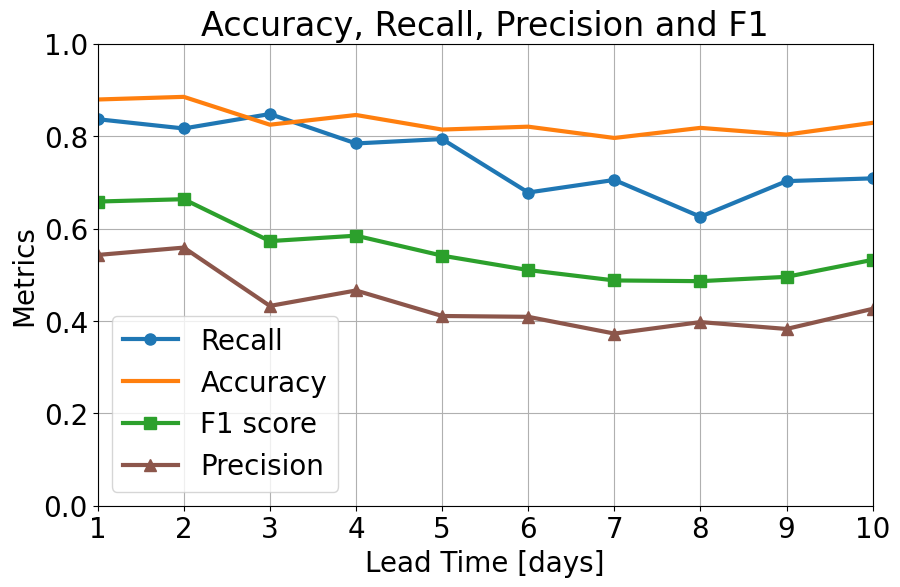

In [133]:
import matplotlib

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined
# Plotting POD
plt.plot(x, rec_lstm, label='Recall', marker='o', color='C0', linewidth=3, markersize=8)
# Plotting Accuracy
plt.plot(x, acc_lstm, label='Accuracy', color='C1', linewidth=3, markersize=8)
# Plotting F1
plt.plot(x, f1_lstm, label='F1 score', marker='s', color='C2', linewidth=3, markersize=8)
# Plotting Precision
plt.plot(x, prec_lstm, label='Precision', marker='^', color='C5', linewidth=3, markersize=8)


plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('Metrics')
plt.title('Accuracy, Recall, Precision and F1')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

# Evaluate Ensemble model

In [134]:
from sklearn.metrics import confusion_matrix

tp_arr = []
tn_arr = []
fp_arr = []
fn_arr = []

for i in range(10):
  tn, fp, fn, tp = confusion_matrix(y_test_hybrid[i], predictions_hybrid[i]).ravel()
  tp_arr.append(tp)
  tn_arr.append(tn)
  fp_arr.append(fp)
  fn_arr.append(fn)

tp_hb = tp_arr
tn_hb = tn_arr
fp_hb = fp_arr
fn_hb = fn_arr

In [135]:
acc_hb   = []
rec_hb   = []
prec_hb  = []
f1_hb    = []
far_hb   = []

for i in range(10):
  acc_hb.append(sklearn.metrics.accuracy_score(y_test_hybrid[i], predictions_hybrid[i]))
  rec_hb.append(sklearn.metrics.recall_score(y_test_hybrid[i], predictions_hybrid[i]))
  prec_hb.append(sklearn.metrics.precision_score(y_test_hybrid[i], predictions_hybrid[i]))
  f1_hb.append(sklearn.metrics.f1_score(y_test_hybrid[i], predictions_hybrid[i]))
  far_hb.append(fp_arr[i]/(fp_arr[i]+tp_arr[i]))

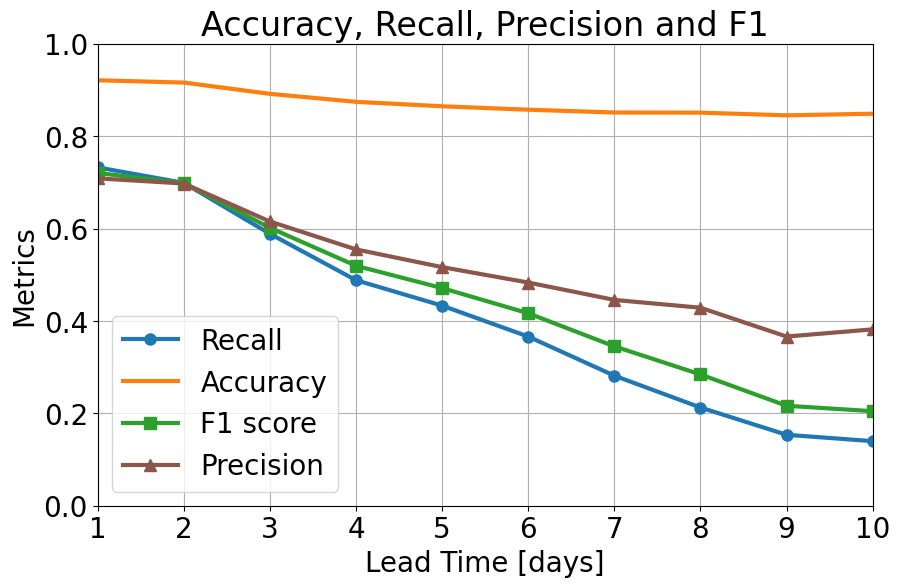

In [136]:
import matplotlib

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined
# Plotting POD
plt.plot(x, rec_hb, label='Recall', marker='o', color='C0', linewidth=3, markersize=8)
# Plotting Accuracy
plt.plot(x, acc_hb, label='Accuracy', color='C1', linewidth=3, markersize=8)
# Plotting F1
plt.plot(x, f1_hb, label='F1 score', marker='s', color='C2', linewidth=3, markersize=8)
# Plotting Precision
plt.plot(x, prec_hb, label='Precision', marker='^', color='C5', linewidth=3, markersize=8)


plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.ylabel('Metrics')
plt.title('Accuracy, Recall, Precision and F1')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

# Evaluate all the models

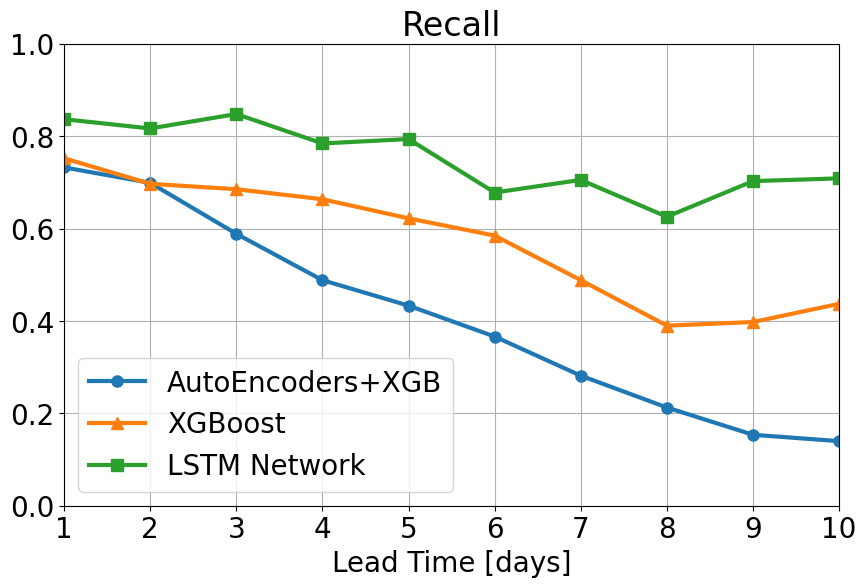

In [138]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined

# Plotting Recall
plt.plot(x, rec_hb, label='AutoEncoders+XGB', marker='o', color='C0', linewidth=3, markersize=8)
# Plotting Recall
plt.plot(x, rec_xgb, label='XGBoost', marker='^', color='C1', linewidth=3, markersize=8)
# Plotting Recall
plt.plot(x, rec_lstm, label='LSTM Network', marker='s', color='C2', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.title('Recall')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

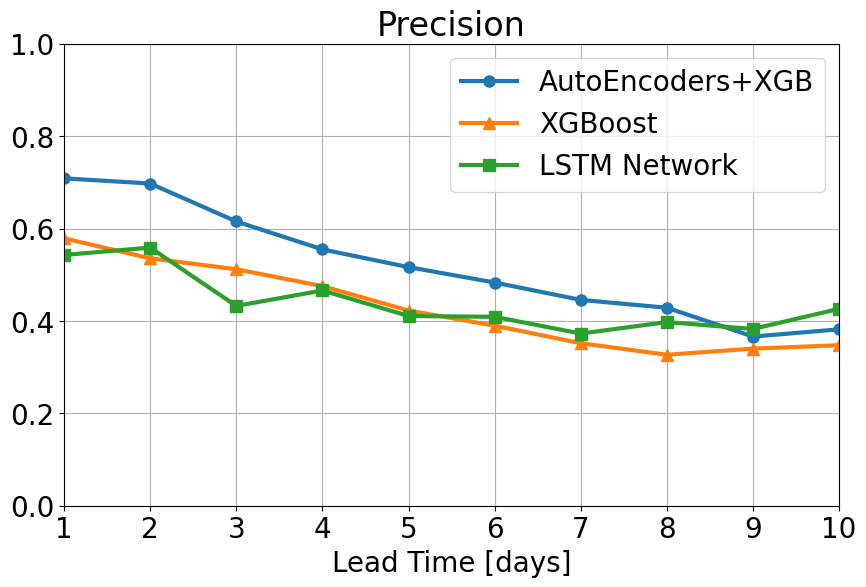

In [139]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined

# Plotting Precision
plt.plot(x, prec_hb, label='AutoEncoders+XGB', marker='o', color='C0', linewidth=3, markersize=8)
plt.plot(x, prec_xgb, label='XGBoost', marker='^', color='C1', linewidth=3, markersize=8)
plt.plot(x, prec_lstm, label='LSTM Network', marker='s', color='C2', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.title('Precision')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

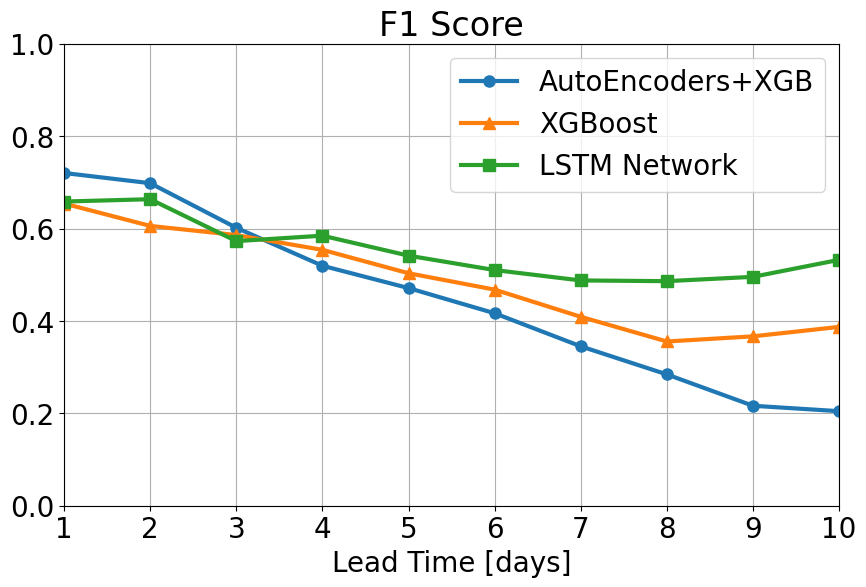

In [140]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined

# Plotting F1
plt.plot(x, f1_hb, label='AutoEncoders+XGB', marker='o', color='C0', linewidth=3, markersize=8)
plt.plot(x, f1_xgb, label='XGBoost', marker='^', color='C1', linewidth=3, markersize=8)
plt.plot(x, f1_lstm, label='LSTM Network', marker='s', color='C2', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.title('F1 Score')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

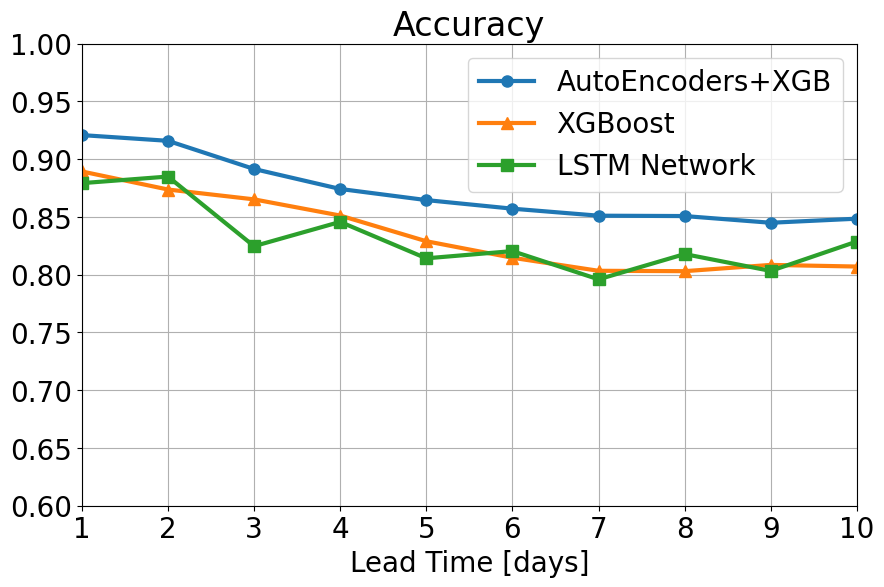

In [141]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined

# Plotting Accuracy
plt.plot(x, acc_hb, label='AutoEncoders+XGB', marker='o', color='C0', linewidth=3, markersize=8)
plt.plot(x, acc_xgb, label='XGBoost', marker='^', color='C1', linewidth=3, markersize=8)
plt.plot(x, acc_lstm, label='LSTM Network', marker='s', color='C2', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0.6, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.title('Accuracy')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

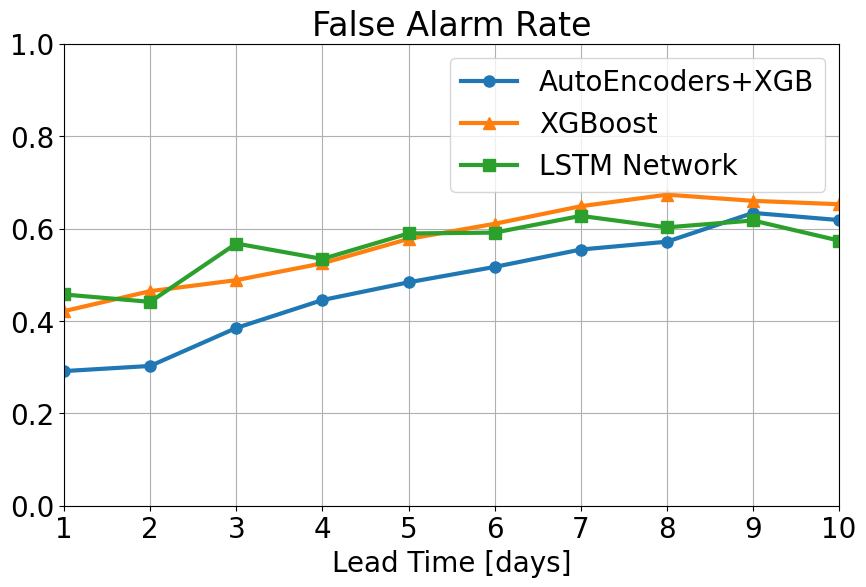

In [142]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 6))  # Adjust width and height as needed
# Assuming df_metrics_test, test_pod, and test_acc are already defined

# Plotting Accuracy
plt.plot(x, far_hb, label='AutoEncoders+XGB', marker='o', color='C0', linewidth=3, markersize=8)
plt.plot(x, far_xgb, label='XGBoost', marker='^', color='C1', linewidth=3, markersize=8)
plt.plot(x, far_lstm, label='LSTM Network', marker='s', color='C2', linewidth=3, markersize=8)

plt.xlim(1, 10)  # Adjust the range based on your data
plt.ylim(0, 1)  # Adjust the range based on your data
plt.xticks(x)

# Adding labels and title
plt.xlabel('Lead Time [days]')
plt.title('False Alarm Rate')
plt.grid()
# Adding legend
plt.legend()

# Display the plot
plt.show()

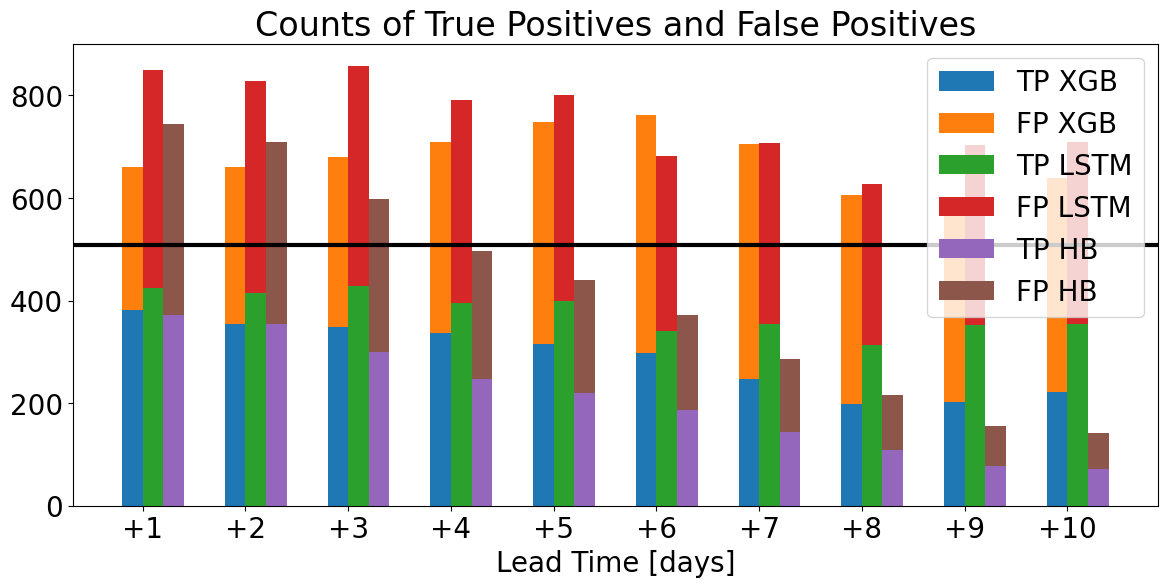

In [172]:
# Data
N_cyclones = 508
days = ['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8', '+9', '+10']

fig, ax = plt.subplots(figsize=(14,6))
# Bar width
bar_width = 0.2
# Positions for the bars
pos_1 = range(len(days))
pos_2 = [p + bar_width for p in pos_1]
pos_3 = [p + bar_width for p in pos_2]


# Plot tp and tn
ax.bar(pos_1, tp_xgb, width=bar_width, label='TP XGB')
ax.bar(pos_1, fp_xgb, width=bar_width, label='FP XGB', bottom=tp_xgb)


ax.bar(pos_2, tp_lstm, width=bar_width, label='TP LSTM')
ax.bar(pos_2, tp_lstm, width=bar_width, label='FP LSTM', bottom=tp_lstm)


ax.bar(pos_3, tp_hb, width=bar_width, label='TP HB')
ax.bar(pos_3, tp_hb, width=bar_width, label='FP HB', bottom=tp_hb)

plt.axhline(y=N_cyclones, color='black', linestyle='-', linewidth=3)


# Set x-axis ticks and labels
ax.set_xticks([p + bar_width / 2 for p in pos_1])
ax.set_xticklabels(days)
# Add labels and legend
ax.set_xlabel('Lead Time [days]')
ax.set_ylabel('')
ax.set_title('Counts of True Positives and False Positives')
ax.legend()
plt.show()